In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from os import listdir

import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [2]:
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Conputation is running on {}'.format(device))

This Conputation is running on cpu


Bilder importieren
-

In [3]:
transforms = transforms.Compose([transforms.Resize(32),
                                 transforms.CenterCrop(32),
                                 transforms.ToTensor()
                                ])
#transforms = transforms.ToTensor()
#Batch_size definieren, um Variable wieder zu verwenden und spätere Fehler zu vermeiden
#batchSize = 7 - BatchSize für Simpsonbilder

batchSize = 10
channels = 3
image_size = 32
input_dim = channels*image_size*image_size

#Bilder aus dem verzeichnis in einen Tensor schreiben
true_images_list = []
for f in listdir('C:/Users/meldr/PythonProjects/GAN-Bilder/AnimeTMgroß/'):
    img = Image.open("C:/Users/meldr/PythonProjects/GAN-Bilder/AnimeTMgroß/" + f) # f ist gleich der Dateiname
    img_tensor = transforms(img) #(3,100,100)
    true_images_list.append(img_tensor)
train_data = torch.stack(true_images_list) #Liste mit Image-Tensoren

#DataLoader für echte Bilder
trueloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=True, num_workers=1) #pin_memory=True -> GPU

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__() #Superkonstruktor für das NN
        #decoder
        #batch_size = 4, size = 2500 (50x50 Pixel)
        #output size = (inputsize-1)*stride - 2*padding + (kernelsize-1)+1
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(3, 16, 4, stride=2, padding=2), #Output Generator:torch.Size([10, 16, 14, 14])
            nn.ReLU(), #Relu-Aktivierungsfunktion
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 32, 6, stride=1, padding=2), #Output Generator:torch.Size([10, 32, 15, 15])
            nn.ReLU(), #Relu-Aktivierungsfunktion
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 6, stride=2, padding=1), #Output Generator:torch.Size([10, 3, 32, 32])
            #Sigmoid-Aktivierungsfunktion, wenn unsere Werte zwischen 0 und 1 sind
            #Tanh-Aktivierungsfunktion, wenn unsere Werte zwischen -1 und 1 sind
            nn.Sigmoid() 
        )
        
    def forward(self,x):
        #print(f'Input Generator:{x.shape}')
        generated = self.generate(x)
        #print(f'Output Generator:{generated.shape}')
        return generated
    


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__() #Superkonstruktor für das NN
        
        #batch_size = 4, size = 2500 (50x50 Pixel)
        self.discriminate = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=2, padding=1), # 2500=(1+2500-5+2*2)/1
            nn.ReLU(), #Relu-Aktivierungsfunktion
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 5, stride=2, padding=1), # 625=(1+2500-5+2*2)/2
            nn.ReLU(), #Relu-Aktivierungsfunktion
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, 5, stride=2, padding=2), # 125=(1+625-5+2*2)/2
            nn.Sigmoid() 
        )
        
    def forward(self,x):
        #print(f'Input Discriminator:{x.shape}')
        discriminated = self.discriminate(x)
        #print(f'Output Discriminator:{discriminated.shape}')
        return discriminated
    


In [6]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss().to(device)
gen_optimizer = optim.Adam(generator.parameters(), lr=0.001)
discr_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

In [7]:
#Definition der Target-Werte, um den Loss zu berechnen
#true_target = torch.ones(batchSize, 256, 197, 197, dtype=torch.float).to(device)
#Die echten Inputs sollen auf den Wert 1 trainiert werden
#torch.ones: Gibt einen Tensor zurück, der mit dem Skalarwert 1 gefüllt ist  
#und dessen Form durch das variable Argument size definiert ist. 
#Bspw. torch.ones(5) -> tensor([ 1.,  1.,  1.,  1.,  1.])

#false_target = torch.zeros(batchSize,125,3,3, dtype=torch.long).to(device)
#Die falschen Inputs sollen auf en Wert 0 trainiert werden
#torch.zeros: Gibt einen Tensor zurück, der mit dem Skalarwert 0 gefüllt ist  
#und dessen Form durch das variable Argument size definiert ist. 
#Bspw. torch.zeros(5) -> tensor([ 0.,  0.,  0.,  0.,  0.])
outputs = []
real_outputs = []   
fake_outputs = [] 
foutput = None

fake_image = torch.rand(batchSize,3,8,8,device=device)
for epoch in range(5):
    #cuda-cache leeren
    print('Epoche:' + epoch)
    gc.collect()
    torch.cuda.empty_cache()

    for true_image in trueloader:
       
        #1.Erstellung einer Random-Noise
        #fake_image = torch.rand(batchSize,3,50,50).to(device) #torch.Size([3, 200, 200])
              
        
        ###### Train Generator
        #Gradienten des Generators zurücksetzen
        gen_optimizer.zero_grad()    
        
        #G.1 Daten mit der Random-Noise generieren
        fake_generated = generator(fake_image)
        #G.2 Fehler mit der fake_generated und den Target 11111... berechnen
        loss_gen_fake = criterion(fake_generated,torch.ones(batchSize, 3, 32, 32, dtype=torch.float, device=device))   
        #G.3 Backpropagation für die fake_generated des Generators        
        loss_gen_fake.backward()
        #G.4 Gewichte des Generators mit dem Gradienten aktualisieren
        gen_optimizer.step()    
        #G.5 Generated Image in outputs speichern
            
            
        ####### Train Discriminator
        #Gradienten des Discriminators zurücksetzen
        discr_optimizer.zero_grad()
    
        #D.1 Train Discriminator mit generierten Fake-Images
        fake_prediction = discriminator(fake_generated.detach())
        #D.2 Fehler mit der fake_prediction und den Target 11111... berechnen
        loss_discr_fake = criterion(fake_prediction, torch.zeros(batchSize,16, 4, 4, dtype=torch.float, device=device))
        #D.3 Backpropagation für die Fake-Prediction des Discriminators
        loss_discr_fake.backward()
        #D.4 Train Discriminator mit True-Images
        true_prediction = discriminator(true_image.to(device))
        #D.5 Fehler mit der true_prediction und den Target 11111... berechnen
        loss_discr_true = criterion(true_prediction, torch.ones(batchSize,16, 4, 4, dtype=torch.float,device=device))
        #D.6 Backpropagation für die True-Prediction des Discriminators
        loss_discr_true.backward()

        #D.7 Gewichte des Discriminators mit dem Gradienten aktualisieren
        discr_optimizer.step()
        
        real_outputs.append(true_image)   
        fake_outputs.append(fake_generated)
        foutput = fake_generated.cpu()
        #print(foutput.shape)


0
1
2
3
4


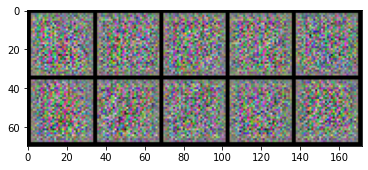

In [8]:
##outputs.append((true_image,fake_generated)) 
###outputs[art][batch][image]

#outputs[0] -> Alle Batches (10) mit true_images
#outputs[0][i] -> i-ter Batch mit 10 true_images
#outputs[0][i][n] -> i-ter Batch mit dem n-ten true_images aus dem batch

#outputs[1] -> Alle Batches (10) mit true_images
#outputs[1][i] -> i-ter Batch mit 10 true_images
#outputs[1][i][n] -> i-ter Batch mit dem n-ten true_images aus dem batch
#Epochen = 5 - Batches = 520 - Batchgröße = 10
for epoch in range(5):
    for batch in range(1):
        #true_batch = outputs[0][batch]
        fake_batch = fake_outputs[batch]
        #true_grid_img = torchvision.utils.make_grid(true_batch, nrow=10).cpu()
        fake_grid_img = torchvision.utils.make_grid(fake_batch, nrow=5).cpu()
        #plt.imshow(true_grid_img.permute(1, 2, 0))
        plt.imshow(fake_grid_img.permute(1, 2, 0))

In [9]:
#print(foutput.shape)
#print(foutput.type)
tup_foutput = []
tup_foutput = torch.tensor_split(foutput, 10, dim=0)
arr_foutput = []
for x in tup_foutput:
    x = torch.squeeze(x)
    print(x.shape)
    arr_foutput.append(x)
print(type(arr_foutput))
print(len(arr_foutput))

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
<class 'list'>
10


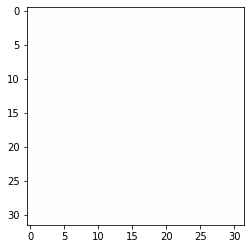

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Erhalten Sie zufällig Trainingsbilder
#dataiter = iter(arr_foutput)
#images, labels = dataiter.next()

# Bild anzeigen
#imshow(torchvision.utils.make_grid(arr_foutput))


#Einzelnes Bild ausgeben
img = arr_foutput[0].detach().numpy()
nimg = np.transpose(img, (1, 2, 0))
plt.imshow(nimg)
plt.show()